### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [40]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1


#### Notes
#correlation matrix
#chi square matrix
#r2 value accuracy
#Mlp
#deep learning pytorch
#scaling the data
#decicion treees - distribution - scaled data = good


It could be relevant to use principle component analysis and then use clustering to look for pattern and trends.

In [41]:
import pandas as pd
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
#keep in mind that the file is encoded in UTF-8, so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [42]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32
#printing the unique values from column 'Hovedområde start'
print(df['Hovedområde start'].unique())
#the hovedområde stopp and hovedområde start is identical.

[nan 'Bjørnøya' 'Røstbanken til Malangsgrunnen' 'Sentralbanken'
 'Nordkappbanken' 'Shetland' 'Vikingbanken' 'Øst-Finnmark' 'Vest-Finnmark'
 'Kaninbanken' 'Skolpenbanken' 'Skagerrak' 'Eigersundbanken'
 'Storegga-Frøyabanken' 'Vestfjorden (Lofoten)' 'Gåsebanken'
 'Thor Iversens Bank' 'Helgelandsbanken' 'Sørvest av Spitsbergen'
 'Vest av Skottland (Hebridene)' 'Vestlige Norskehav' 'Østlige Norskehav'
 'Øst av Færøyene' 'Storbanken' 'Hopen' 'Sentrale Nordsjø'
 'Sørlige Nordsjø' 'Murmanskkysten' 'Sørvestlige Norskehav'
 'Nordøst av Island' 'Sørlige Norskehav' 'Vest av Tromsøflaket'
 'Nord av Island' 'Vest av Irland' 'Sørvest av Island' 'Øst av Island'
 'Rockall' 'Admiralityfeltet' 'Britvinfeltet' 'Sørvest av Irland'
 'Skjoldungen' 'Danmarkstredet' 'Færøybanken' 'Vest av Færøyene'
 'Flemish Cap' 'Vest-Spitsbergen' 'Nordv.- Spitsbergen'
 'Storfjord/Hinlopenstredet' 'Nordøstområdet' 'Nord av Horn  (Island)'
 'Sør for Jan Mayen' 'Sentrale Norskehav' 'Nordvestlige Norskehav'
 'Grønlandshavet' 'F

In [43]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969","Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" only having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett", "Starttidspunkt", "Stopptidspunkt"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde stopp"], inplace=True)

In [44]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()

In [45]:
# Focusing down on the species we want to investigate
# More might be added later as categories or ranges
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [46]:
# Removing parts of columns
# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.
df = df[df['Varighet'] <= 400]
# Maybe remove some outliers from "Trekkavstand". Above 50000 the frequency gets 100 instances per 5000 length.
# Just doing it for now, unsure of necessity
df = df[df['Trekkavstand'] <= 50000]

In [47]:
# Manipulating columns

# The coordinates are strings, here I'm changing them to int so they're easier to use.
# Later we might potentially change them in a different way.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

# Date/time could potentially be changed to month/hour?
df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]
df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()

In [48]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
# df = df.pivot_table(index=['Melding ID', 'Startdato', 'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
df = df.pivot_table(index=['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
# This creates a lot of nan values which we fill with 0
df = df.fillna(0)

# We add another column to indicate which was the dominant catch during that session
# Might be removed or deemed redunadant later on as it has a 86% match to "Hovedfangst FAO"
df['Hovedfangst'] = df[['Hyse', 'Sei', 'Torsk']].idxmax(axis=1)

print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")

After pre-processing the dataset has 20 columns and 50696 rows


In [49]:
column_names = df.columns.tolist()
print(column_names)

['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO', 'Bruttotonnasje', 'Hyse', 'Sei', 'Torsk', 'Hovedfangst']


In [50]:
#transforming columns to int
df['Trekkavstand'] = df['Trekkavstand'].astype(int)
df['Bruttotonnasje'] = df['Bruttotonnasje'].astype(int)
df['Hyse'] = df['Hyse'].astype(int)
df['Sei'] = df['Sei'].astype(int)
df['Torsk'] = df['Torsk'].astype(int)
df['Startmåned'] = df['Startmåned'].astype(int)
df['Starttime'] = df['Starttime'].astype(int)
df['Stoppmåned'] = df['Stoppmåned'].astype(int)
df['Stopptime'] = df['Stopptime'].astype(int)

In [51]:
max_values = df[['Hyse', 'Sei', 'Torsk']].max()
print(max_values)

Art FAO
Hyse      53021
Sei      215000
Torsk    444994
dtype: int32


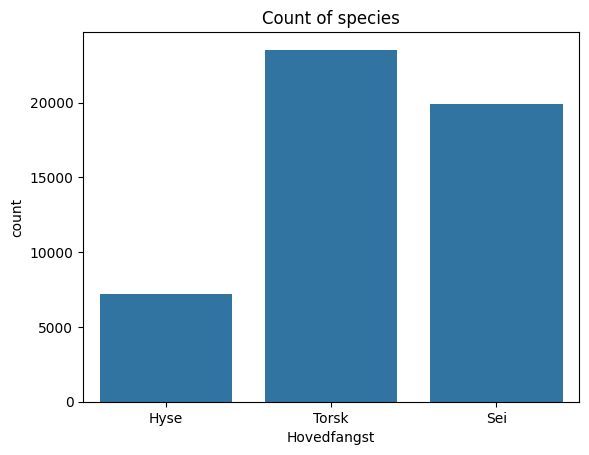

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#presenting the count of the different species in the dataset with a barplot
sns.countplot(x='Hovedfangst', data=df)
plt.title('Count of species')
plt.show() #there is a big difference in the count of Hyse compared to the rest. Would perhaps be better to use Gruppe - Art for more even distribution

#### Visual exploring of data

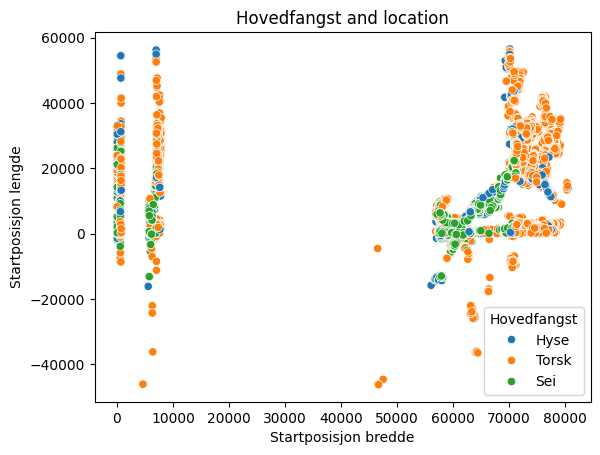

In [53]:
#plotting fish species and location
sns.scatterplot(x='Startposisjon bredde', y='Startposisjon lengde', data=df, hue='Hovedfangst')
plt.title('Hovedfangst and location')
plt.show()
#only problem is that the coordinates are just numbers, so it is hard to see where the coordinates are.
#how can we make coordinates useful?

#### Exploring matrix correlations

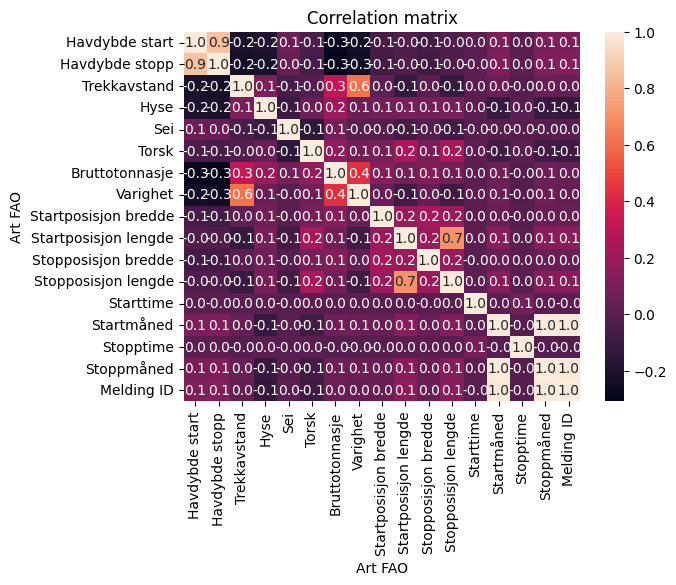

In [54]:
#trying correlation matrix
#defining a correlation matrix version of the dataframe with only the columns with numerical values
df_corr = df[['Havdybde start', 'Havdybde stopp', 'Trekkavstand', 'Hyse', 'Sei', 'Torsk', 'Bruttotonnasje', 'Varighet', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Starttime', 'Startmåned', 'Stopptime', 'Stoppmåned', 'Melding ID']]

#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" )  #.1ft for using one decimal
plt.title('Correlation matrix')
plt.show() #the correlation matrix does not really tell us any strong relationships between relevant features. The non-linear relationships could still be useful for the model though.

Text(0.5, 1.0, 'Correlation matrix of one hot encoded columns with species')

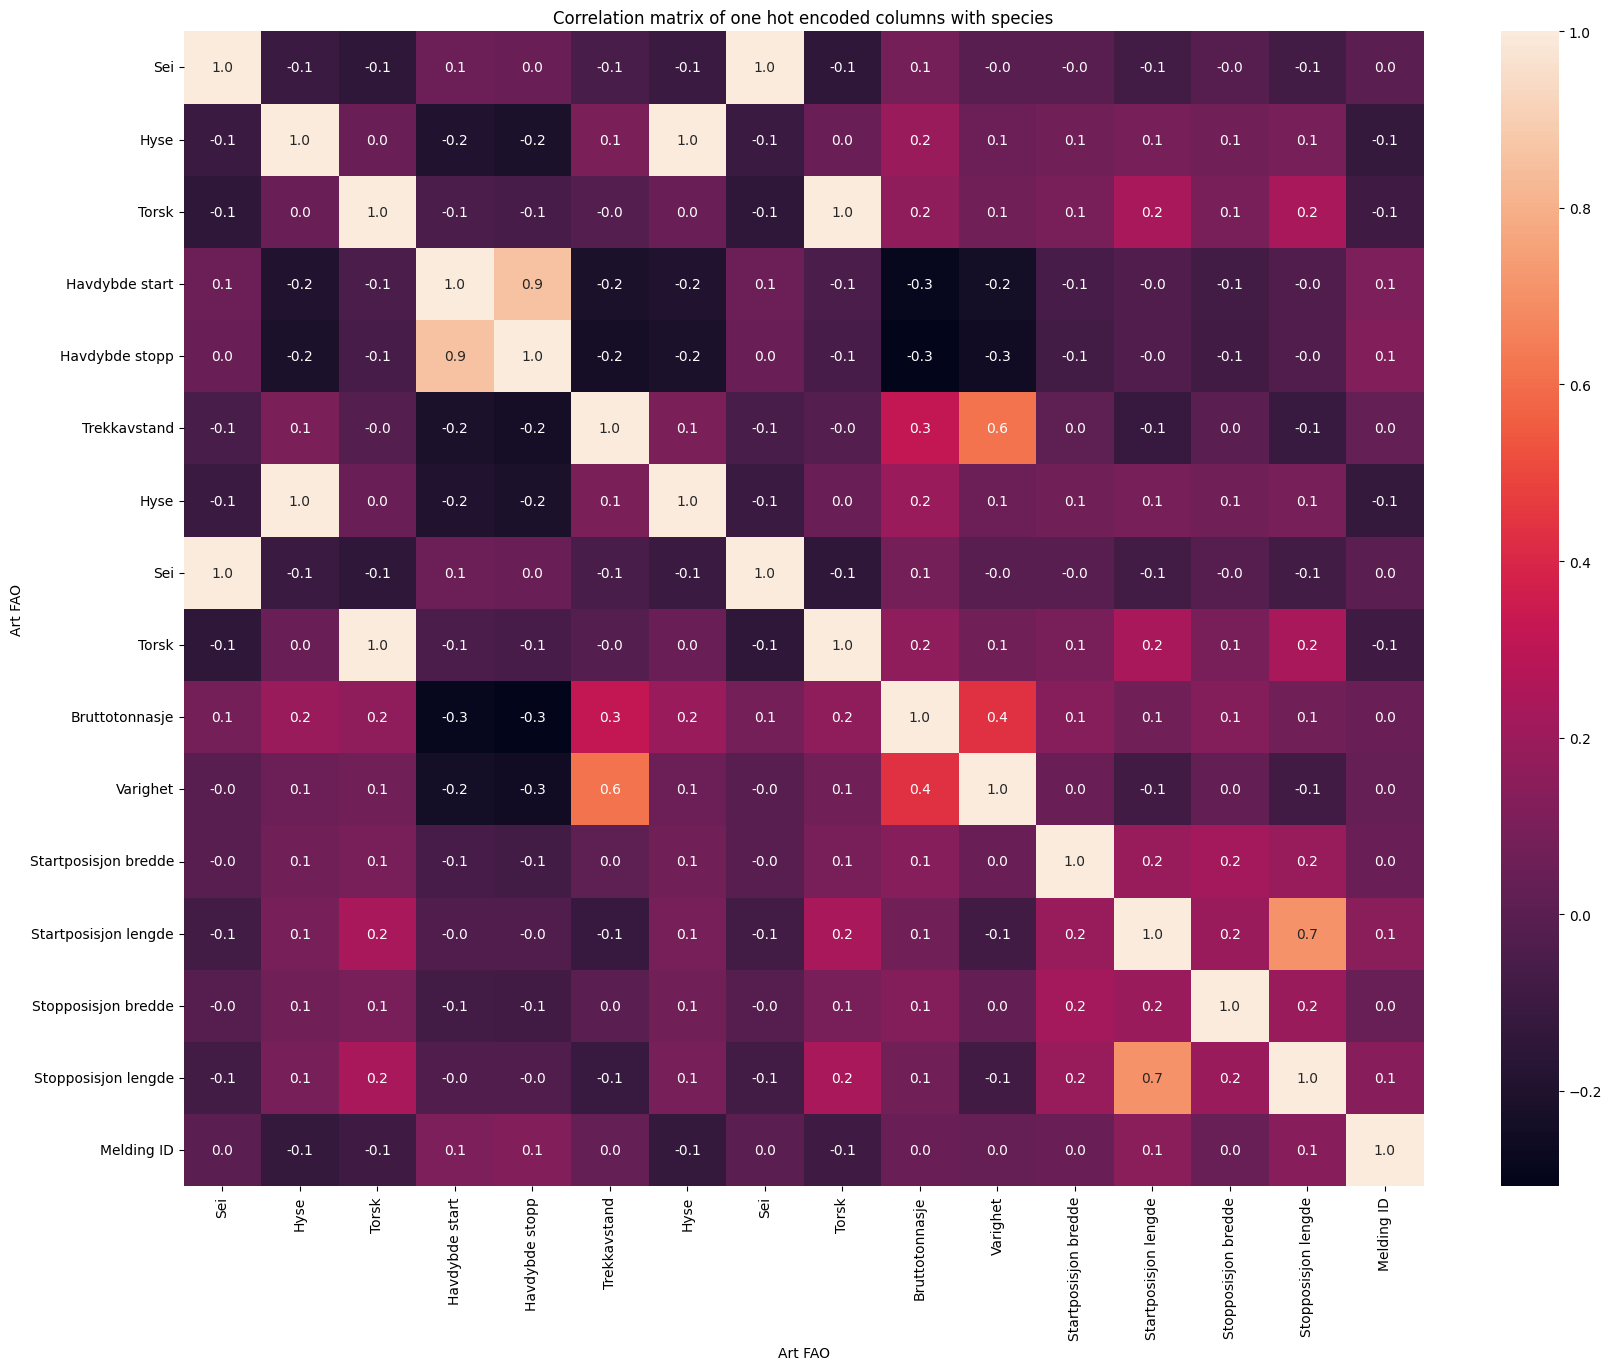

In [55]:
#creating a correlation matrix of all the one hot encoded columns and sei hyse torsk
#correlation matrix for 10 locations at a time
plt.figure(figsize=(20, 15))  # Adjust the dimensions as needed to fit your data
df_corr = df[['Sei', 'Hyse', 'Torsk', 'Havdybde start', 'Havdybde stopp', 'Trekkavstand', 'Hyse', 'Sei', 'Torsk', 'Bruttotonnasje', 'Varighet', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Melding ID']]
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" )  #.1ft for using one decimal
plt.title('Correlation matrix of one hot encoded columns with species')

#tried to look for correlation in the location and species, but it is not showing any strong correlation. 

#### Trying a linear regression model since it works good with continuous values.

##### I am treating the linear regression model as a current benchmark model

In [56]:
# Trying a linear regression model since it works good with continuous values.
# We will try to predict the weight of a species based on the other features.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Splitting the data into training and testing data
#target values will be the weight of the species

#using all values in X
X = df[['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
y = df[['Sei', 'Hyse', 'Torsk']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean squared error: {rmse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
#the mean squared error is very high so the model is not very good. We are working with high values though so it is important to take that into consideration.

[[1827.44 3711.86 8423.75]
 [5964.92 1871.76 3736.01]
 [2162.81 2674.87 6783.78]
 ...
 [3101.   1945.46 4011.33]
 [3012.67  593.88 3755.72]
 [2635.52 1721.   5552.77]]
Root Mean squared error: 6500.2809485353655
R2 score: 0.070449642499269


#### Random forest will be solid if we can feature engineer it good enough

In [57]:
#### trying a random forest model
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# #a random forest model could fit the data better since it is a non-linear model and the correlation matrix did not show any strong linear relationships.
# X= df[['Melding ID', 'Startmåned', 'Starttime', 'Stoppmåned', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
#         'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
# y = df[['Hyse', 'Sei', 'Torsk']]

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed)
# clf = RandomForestRegressor(n_estimators=100, max_features=15, max_depth=40)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)


# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# std = y_test.std()
# print(type(std), type(rmse))
# print("RMSE on test set: ", rmse)
# print("Standard deviation of the target variable: ", std)
# #r2 score
# r2 = r2_score(y_test, y_pred)
# print(f"R2 score: {r2}")

In [58]:
# def plot_feature_importances_cancer(model):
#     n_features = X.shape[1]
#     plt.barh(range(n_features), model.feature_importances_, align='center')
#     plt.yticks(np.arange(n_features), X.keys())
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")
# plot_feature_importances_cancer(clf)

#### How can we feature engineer better?
#correlation matrix , done
#chi square matrix
#r2 value accuracy
#Mlp
#deep learning pytorch
#decicion treees - distribution - scaled data = good
It could be relevant to use principle component analysis and then use clustering to look for pattern and trends.

#### Using our own deep learning model would suit this task well.

Pros
- Neural networks handle continous values well.
- One of the main advantages with DL is their ability to model non-linear relationships.

Cons
- Could be too complicated
- Should only be prioritized after we've chosen our main models.

#### Relevant models for us

### Supervised:
- Decision trees
- Random Forest
- Support Vector Machines   - non-linear classification using what is called the kernel trick

#### Deep Learning Model
Regression Neural Network

### Unsupervised Clustering model
- K-means
- Principal Component Analysis

In [59]:
#trying MLPRegressor since its relevant for our regression problem. Could be the relevant deep learning model.
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

#using all features
""" X = df[['Bruttotonnasje', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Havdybde stopp', 'Trekkavstand', 'Varighet']]
y = df[['Sei', 'Hyse', 'Torsk']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creating the model with , using adam since it converges faster than the other solvers.
model = MLPRegressor(random_state=seed, max_iter=1000, verbose=True) #running 10000 iterations and verbose for seeing the progress
model.fit(X_train, y_train)

#predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean squared error: {rmse}") """


' X = df[[\'Bruttotonnasje\', \'Stopposisjon bredde\', \'Stopposisjon lengde\', \'Startposisjon bredde\', \'Startposisjon lengde\', \'Havdybde start\', \'Havdybde stopp\', \'Trekkavstand\', \'Varighet\']]\ny = df[[\'Sei\', \'Hyse\', \'Torsk\']]\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)\n\n#scaling data\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n#creating the model with , using adam since it converges faster than the other solvers.\nmodel = MLPRegressor(random_state=seed, max_iter=1000, verbose=True) #running 10000 iterations and verbose for seeing the progress\nmodel.fit(X_train, y_train)\n\n#predicting the test data\ny_pred = model.predict(X_test)\nprint(y_pred.round(2))\n#returning the result\nrmse = sqrt(mean_squared_error(y_test, y_pred))\nprint(f"Root Mean squared error: {rmse}") '

skm kernel trick
r2 scores


In [60]:
#trying skm with kernel trick
from sklearn.kernel_ridge import KernelRidge
X = df[['Melding ID', 'Starttime', 'Stopptime', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
y = df[['Sei', 'Hyse', 'Torsk']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creating the model
model = KernelRidge(kernel='rbf')
model.fit(X_train, y_train)

#predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean squared error: {rmse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")